### Now we will try to understand the weak lensing simulation

Then, we will go to imprinting survey properties.

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# GLASS imports
import glass.shells
import glass.fields
import glass.lensing
import glass.galaxies
import glass.ext.camb


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = lmax = 1024

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# linear ramp matter weight function, dz = 0.001 by default, but can be made smaller for more accuracy
ws = glass.shells.tophat_windows(zb, weight=glass.ext.camb.camb_tophat_weight)

In [30]:
cls = glass.ext.camb.matter_cls(pars, lmax, ws)
np.save('cls200_lmax1024.npy', cls)

In [3]:
# load precomputed angular matter power spectra from CAMB using ramp
cls = np.load('cls200_lmax1024.npy')

In [4]:
# compute Gaussian cls for lognormal fields for 3 correlated shells
# putting nside here means that the HEALPix pixel window function is applied
gls = glass.fields.lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

# generator for lognormal matter fields
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

First taste of weak lensing. This does not compute the convergence, rather it initializes a `MultiPlaneConvergence` object with a cosmology.

In [5]:
# this will compute the convergence field iteratively
convergence = glass.lensing.MultiPlaneConvergence(cosmo)

In [6]:
glass.lensing.MultiPlaneConvergence?

Init signature: glass.lensing.MultiPlaneConvergence(cosmo: 'Cosmology') -> None
Docstring:      Compute convergence fields iteratively from multiple matter planes.
Init docstring: Create a new instance to iteratively compute the convergence.
File:           /project/chihway/envs/glass/lib/python3.11/site-packages/glass/lensing.py
Type:           type
Subclasses:     

I don't fully understand what "the actual density per arcmin2 does not matter here, it is never used" means, and why it does not matter. Perhaps they mean the normalization as opposed to the shape. This would explain why `ngal` is always significantly less than 1 in say, the matter_distribution example.

In [7]:
# localised redshift distribution
# the actual density per arcmin2 does not matter here, it is never used
z = np.linspace(0, 1, 101)
dndz = np.exp(-(z - 0.5)**2/(0.1)**2) # gaussian

Text(0, 0.5, 'dn/dz')

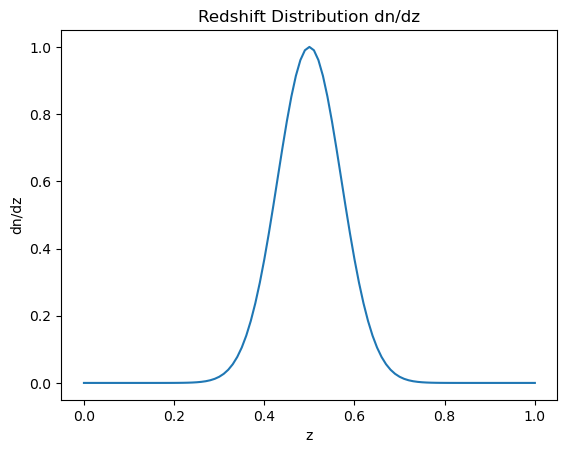

In [8]:
plt.plot(z, dndz)
plt.title('Redshift Distribution dn/dz')
plt.xlabel('z')
plt.ylabel('dn/dz')

\# of healpixels = $12n^2$, where $n$ is nside.

In [9]:
# the integrated convergence and shear field over the redshift distribution
kappa_bar = np.zeros(12*nside**2) # 12 * (nside ** 2) is the number of pixels = hp.nside2npix(nside)
gamm1_bar = np.zeros(12*nside**2)
gamm2_bar = np.zeros(12*nside**2)

In [10]:
# main loop to simulate the matter fields iteratively
for i, delta_i in enumerate(matter):

    # add lensing plane from the window function of this shell
    convergence.add_window(delta_i, ws[i])

    # get convergence field
    kappa_i = convergence.kappa

    # compute shear field
    gamm1_i, gamm2_i = glass.lensing.shear_from_convergence(kappa_i)

    # get the restriction of the dndz to this shell
    z_i, dndz_i = glass.shells.restrict(z, dndz, ws[i])

    # compute the galaxy density in this shell
    ngal = np.trapz(dndz_i, z_i)

    # add to mean fields using the galaxy number density as weight
    kappa_bar += ngal * kappa_i
    gamm1_bar += ngal * gamm1_i
    gamm2_bar += ngal * gamm2_i

In [11]:
# compute the overall galaxy density
ngal = np.trapz(dndz, z)

# normalise mean fields by the total galaxy number density
kappa_bar /= np.sum(ngal)
gamm1_bar /= np.sum(ngal)
gamm2_bar /= np.sum(ngal)

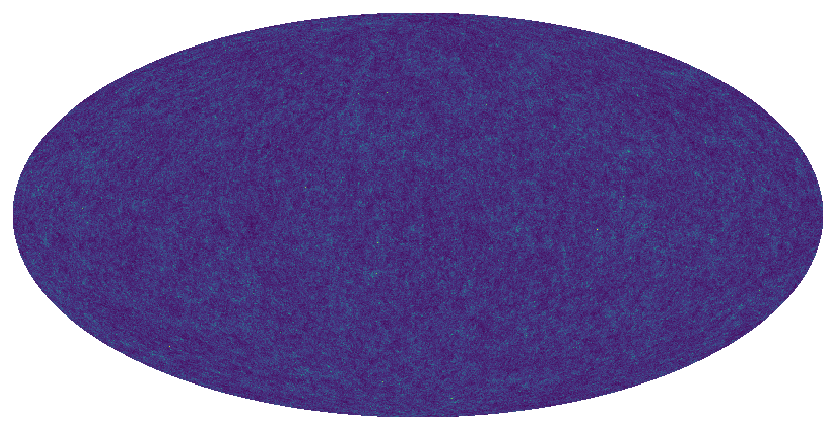

In [29]:
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  # red   with alpha = 30%
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 0.0, 0.0),  # blue  with alpha = 20%
})

hp.mollview(kappa_bar, notext=True, cbar = False, bgcolor=(0.0, 0.0, 0.0, 0.0))
plt.title('')
plt.savefig("convergence.png", transparent = True, dpi = 600)

Text(0.5, 1.0, 'Gamma1 Map')

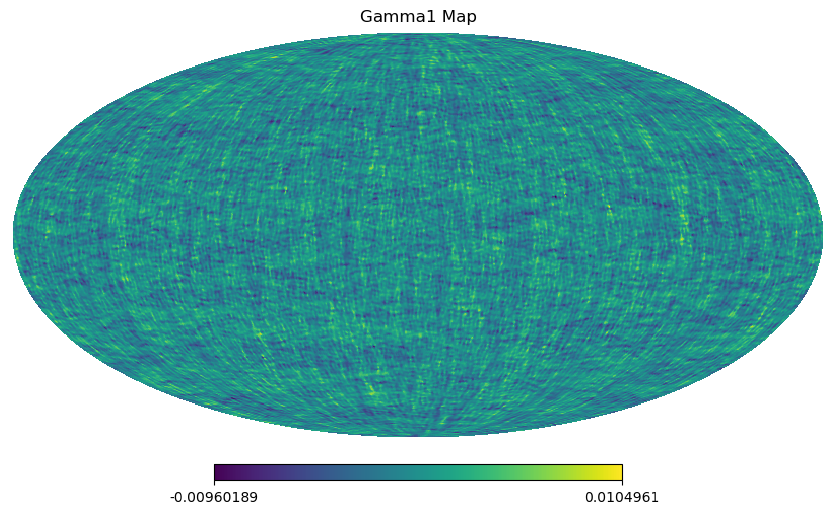

In [ ]:
hp.mollview(gamm1_bar)
plt.title('Gamma1 Map')

Text(0.5, 1.0, 'Gamma2 Map')

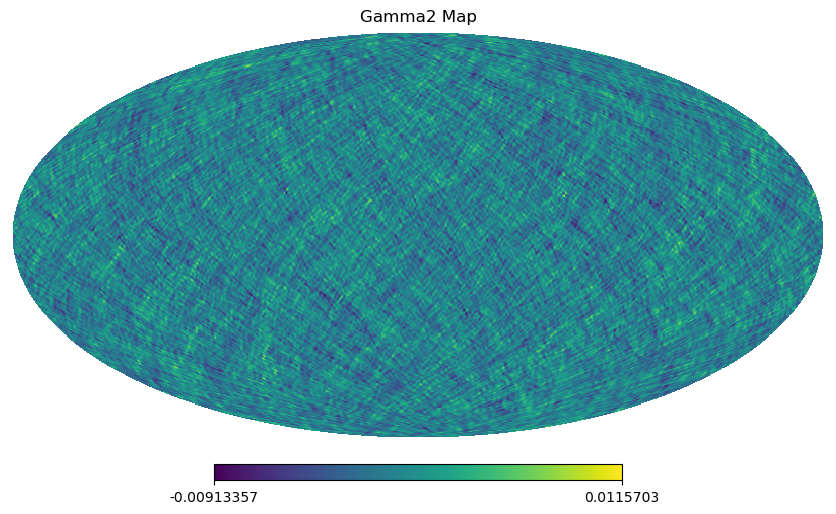

In [ ]:
hp.mollview(gamm2_bar)
plt.title('Gamma2 Map')

`sim_cls` is the correlation function between conv, shear1, shear2, in order: ("$\langle\kappa\kappa \rangle $", "$\langle\gamma_1\gamma_1 \rangle $", "$\langle\gamma_2\gamma_2\rangle$", "$\langle\kappa\gamma_1\rangle$", "$\langle\gamma_1\gamma_2\rangle$", "$\langle\kappa\gamma_2\rangle$")

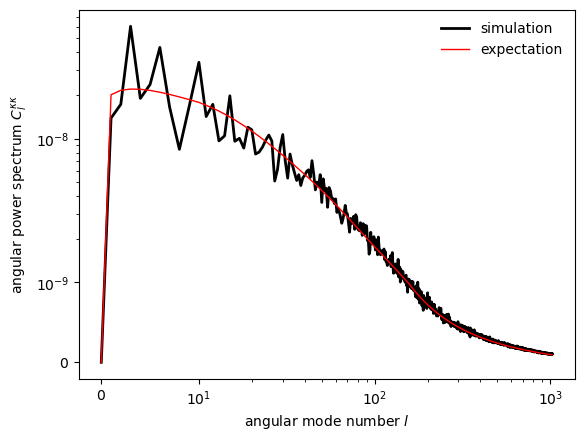

In [16]:
# get the angular power spectra of the lensing maps
sim_cls = hp.anafast([kappa_bar, gamm1_bar, gamm2_bar],
                     pol=True, lmax=lmax, use_pixel_weights=True)

# get the expected cls from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

# get the HEALPix pixel window function, since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

# plot the realised and expected cls
l = np.arange(lmax+1)
plt.plot(l, sim_cls[0], '-k', lw=2, label='simulation')
plt.plot(l, theory_cls['W1xW1']*pw**2, '-r', lw=1, label='expectation')
plt.xscale('symlog', linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale('symlog', linthresh=1e-9, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel(r'angular mode number $l$')
plt.ylabel(r'angular power spectrum $C_l^{\kappa\kappa}$')
plt.legend(frameon=False)
plt.show()

In [16]:
np.save("sim_cls1024.npy", sim_cls[0],)

Find out how to convert this into real space (use cosmosis, talk to Giulia).

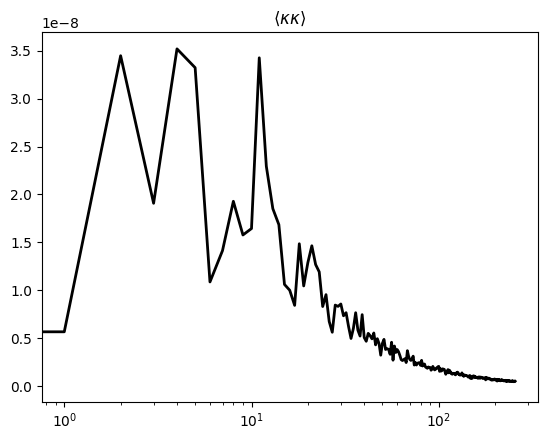

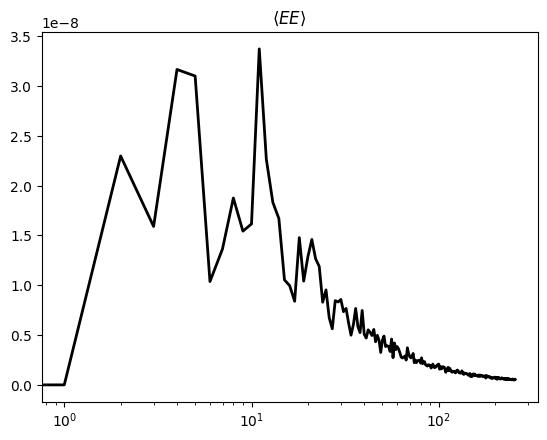

ValueError: 
\langleBB \rangle
^
ParseFatalException: Unknown symbol: \langleBB, found '\'  (at char 0), (line:1, col:1)

<Figure size 640x480 with 1 Axes>

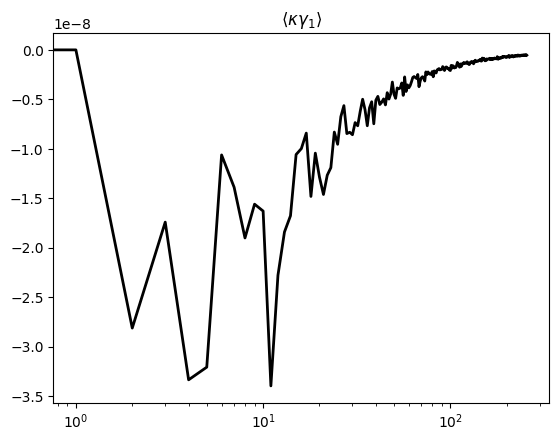

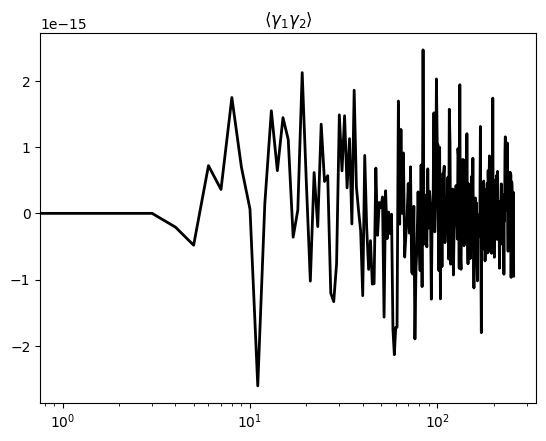

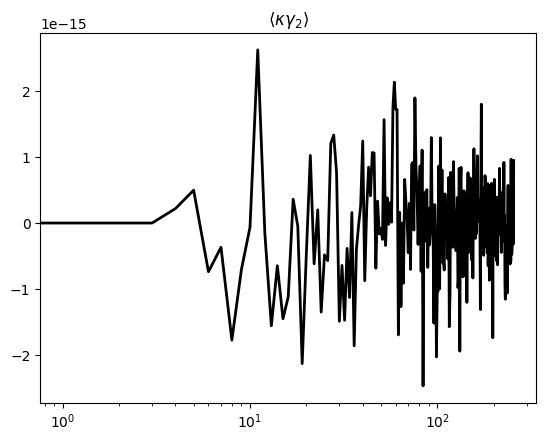

In [16]:
a = ("$\langle\kappa\kappa \\rangle $", "$\langle EE \\rangle $", "$\langleBB \\rangle$", "$\langle\kappa\gamma_1\\rangle$", "$\langle\gamma_1\gamma_2\\rangle$", "$\langle\kappa\gamma_2\\rangle$")
for i in range(6):
    plt.title(a[i])
    plt.plot(l, sim_cls[i], '-k', lw=2)
    plt.semilogx()
    plt.show()
    